In [11]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [12]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [14]:
return_period = 5

In [15]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [47]:
dataset

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-02-09,0.047095,-0.067383,-0.051932,-0.017913,-0.023783,-0.053000,-0.053524,0.518078,-0.040014,-0.020429,0.028411,0.054407
2018-02-16,0.036500,0.045979,0.043646,-0.021815,0.018744,0.042112,0.041636,-0.401002,0.047095,-0.017458,0.059303,0.113313
2018-02-27,-0.009386,0.012534,0.008919,0.002236,-0.008236,0.010263,0.017679,-0.102667,0.015836,0.072770,0.054751,0.127178
2018-03-06,0.011613,-0.014975,-0.005316,-0.013490,-0.001439,-0.005906,-0.020914,-0.012449,-0.009386,0.050625,0.023180,0.124534
2018-03-13,-0.013651,0.034821,0.022855,0.005737,0.007247,0.013540,0.004927,-0.115946,0.011613,0.018063,0.009890,0.105573
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29,0.038370,-0.027538,-0.029807,0.015980,-0.019806,-0.031771,-0.028705,0.152007,-0.014546,-0.084805,-0.204255,-0.111997
2022-10-06,-0.052191,0.040239,0.004921,0.003386,0.007664,0.028181,0.023714,-0.042341,0.038370,0.005730,-0.111102,-0.021624
2022-10-14,0.057635,-0.021718,0.010215,0.022272,0.008242,-0.015670,0.011472,0.020828,-0.024548,-0.040136,-0.130420,-0.145207
2022-10-24,-0.063102,0.025188,0.087937,0.000336,-0.011619,0.031945,0.042603,-0.049667,0.040106,0.026682,-0.075537,-0.124909


In [16]:
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,0.004015,0.001622,0.001497,0.001399,-0.001021,0.001659,0.001366,0.000549,0.003876,0.012514,0.024531,0.058186
std,0.036050,0.038899,0.040442,0.011351,0.013838,0.029199,0.030113,0.162303,0.034740,0.061275,0.075346,0.097462
min,-0.137317,-0.131259,-0.173146,-0.052258,-0.066158,-0.140676,-0.166713,-0.401002,-0.137317,-0.239569,-0.299102,-0.195711
25%,-0.018094,-0.023125,-0.015601,-0.004512,-0.008236,-0.012413,-0.013311,-0.107847,-0.015402,-0.018626,-0.019198,0.000675
50%,0.006046,0.006268,0.004228,0.001118,-0.001083,0.005322,0.002972,-0.019656,0.007575,0.020273,0.033553,0.074615
75%,0.026668,0.025114,0.023281,0.006936,0.006699,0.016685,0.016885,0.083514,0.024913,0.047524,0.073842,0.122021
max,0.164102,0.096339,0.175315,0.052731,0.075400,0.160395,0.183091,0.650554,0.164102,0.244822,0.207462,0.293344


In [17]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-02-09,0.047095,-0.067383,-0.051932,-0.017913,-0.023783,-0.053000,-0.053524,0.518078,-0.040014,-0.020429,0.028411,0.054407
2018-02-16,0.036500,0.045979,0.043646,-0.021815,0.018744,0.042112,0.041636,-0.401002,0.047095,-0.017458,0.059303,0.113313
2018-02-27,-0.009386,0.012534,0.008919,0.002236,-0.008236,0.010263,0.017679,-0.102667,0.015836,0.072770,0.054751,0.127178
2018-03-06,0.011613,-0.014975,-0.005316,-0.013490,-0.001439,-0.005906,-0.020914,-0.012449,-0.009386,0.050625,0.023180,0.124534
2018-03-13,-0.013651,0.034821,0.022855,0.005737,0.007247,0.013540,0.004927,-0.115946,0.011613,0.018063,0.009890,0.105573


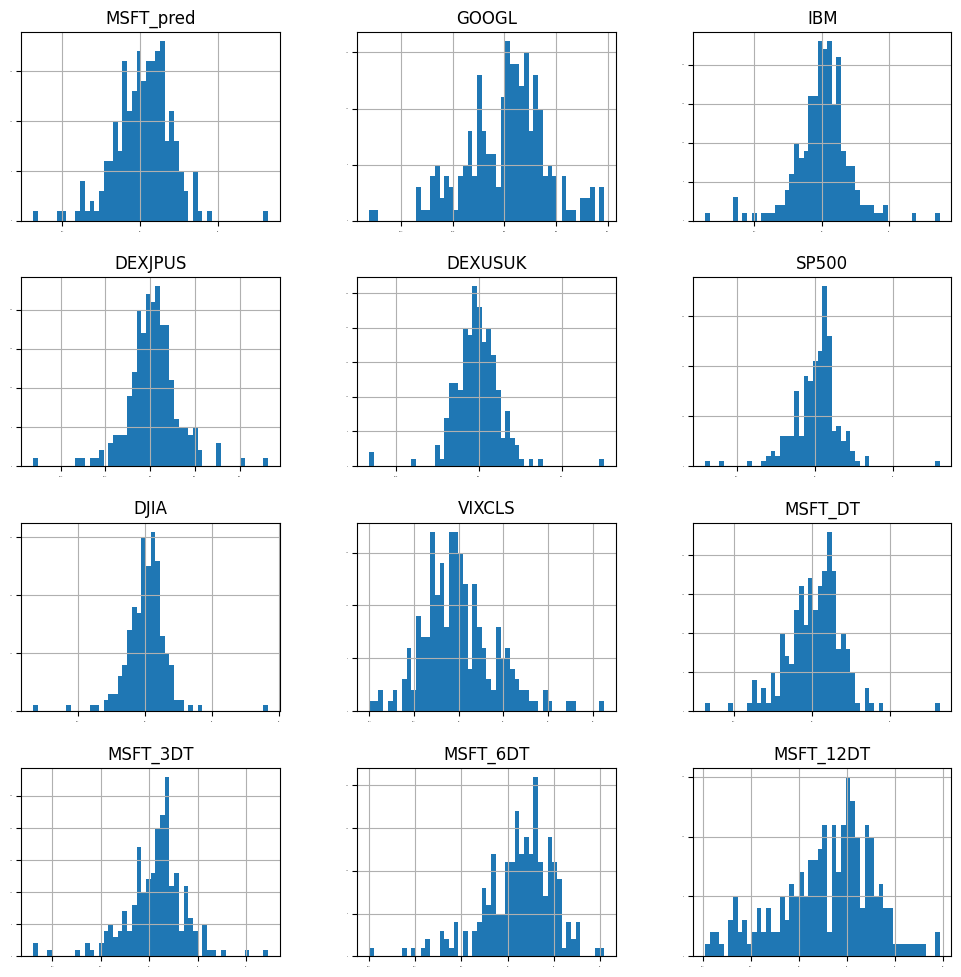

In [18]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

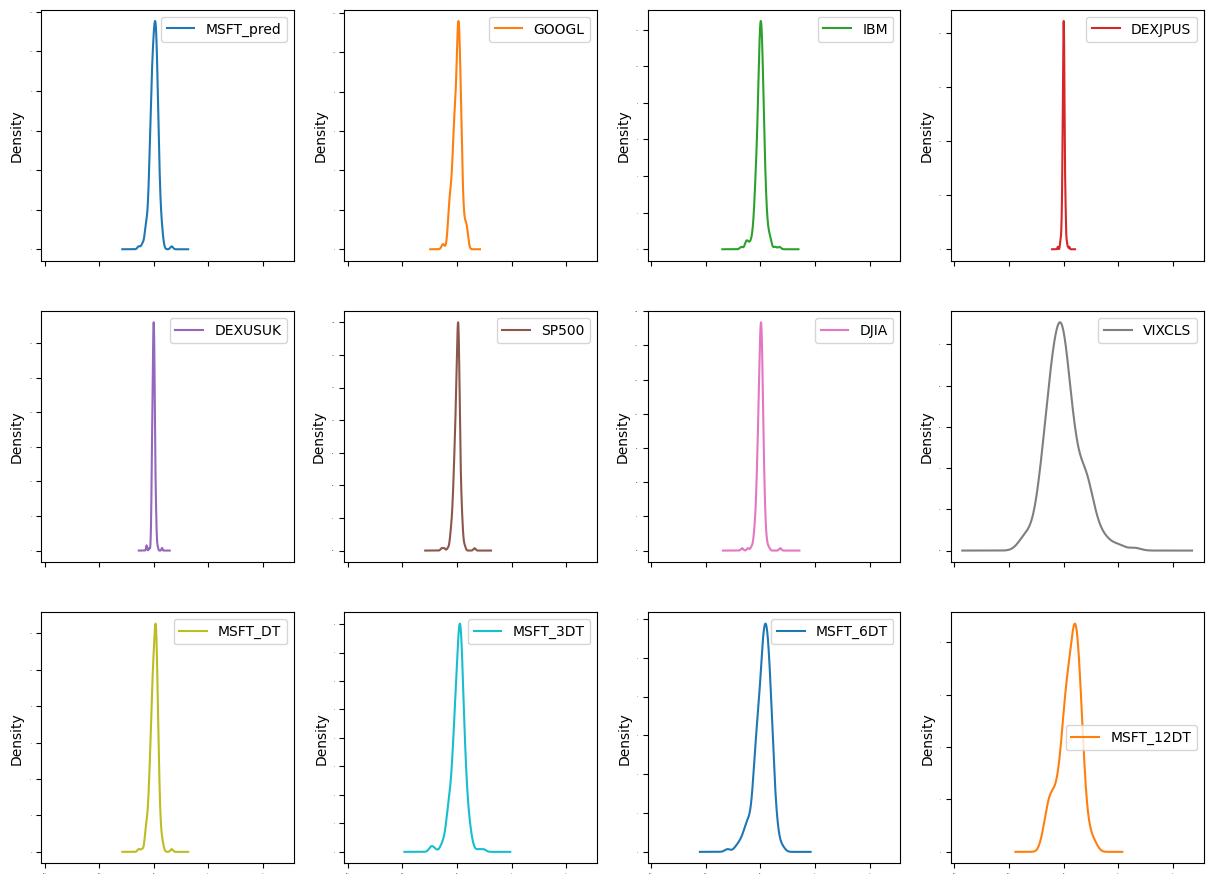

In [19]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

<AxesSubplot: title={'center': 'Correlation Matrix'}>

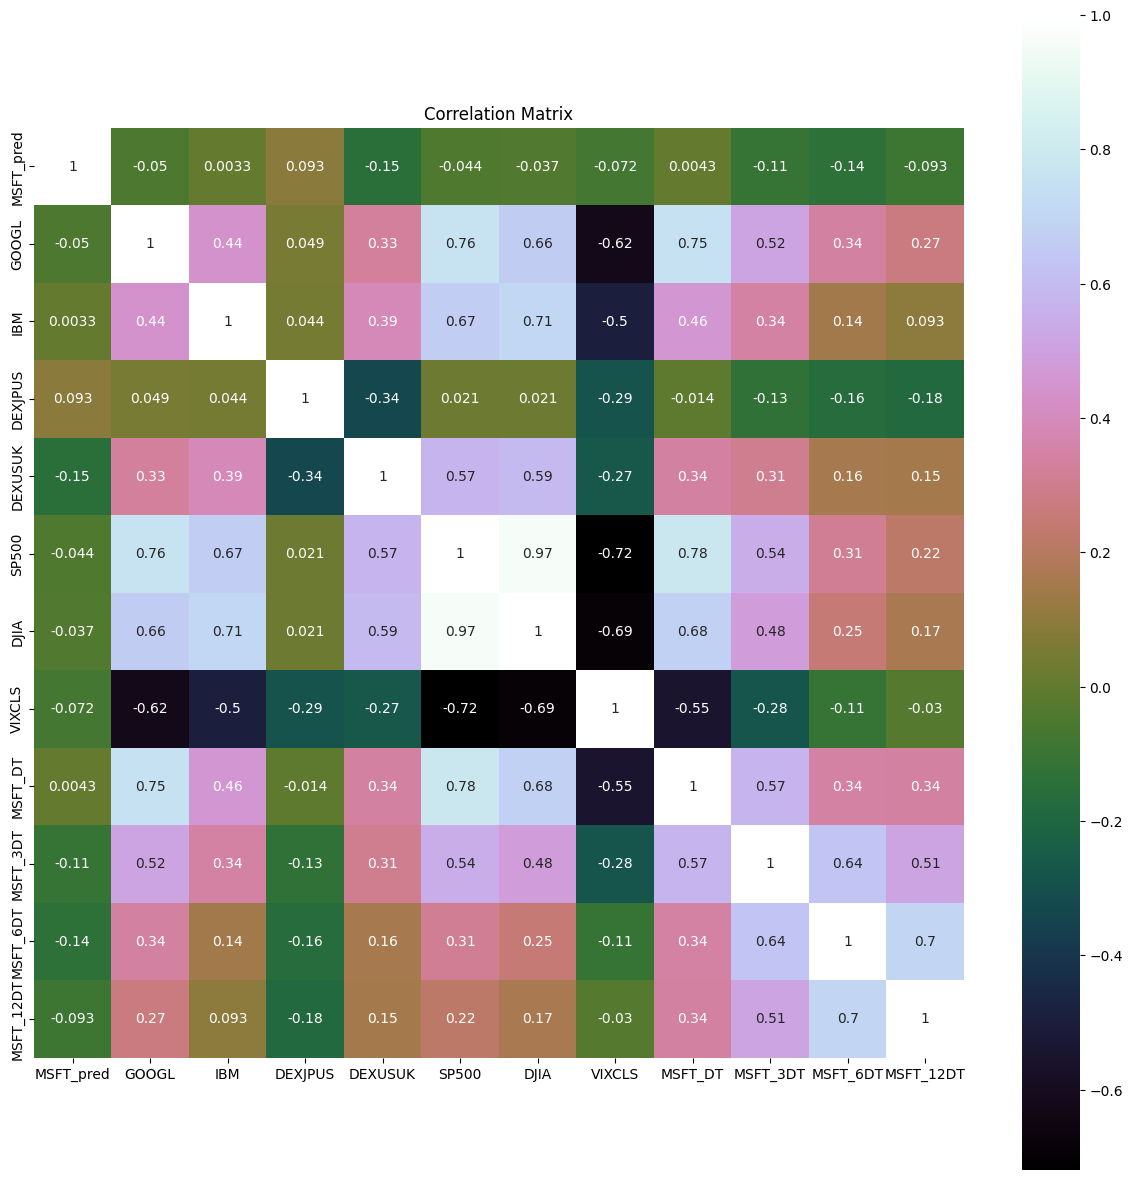

In [20]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

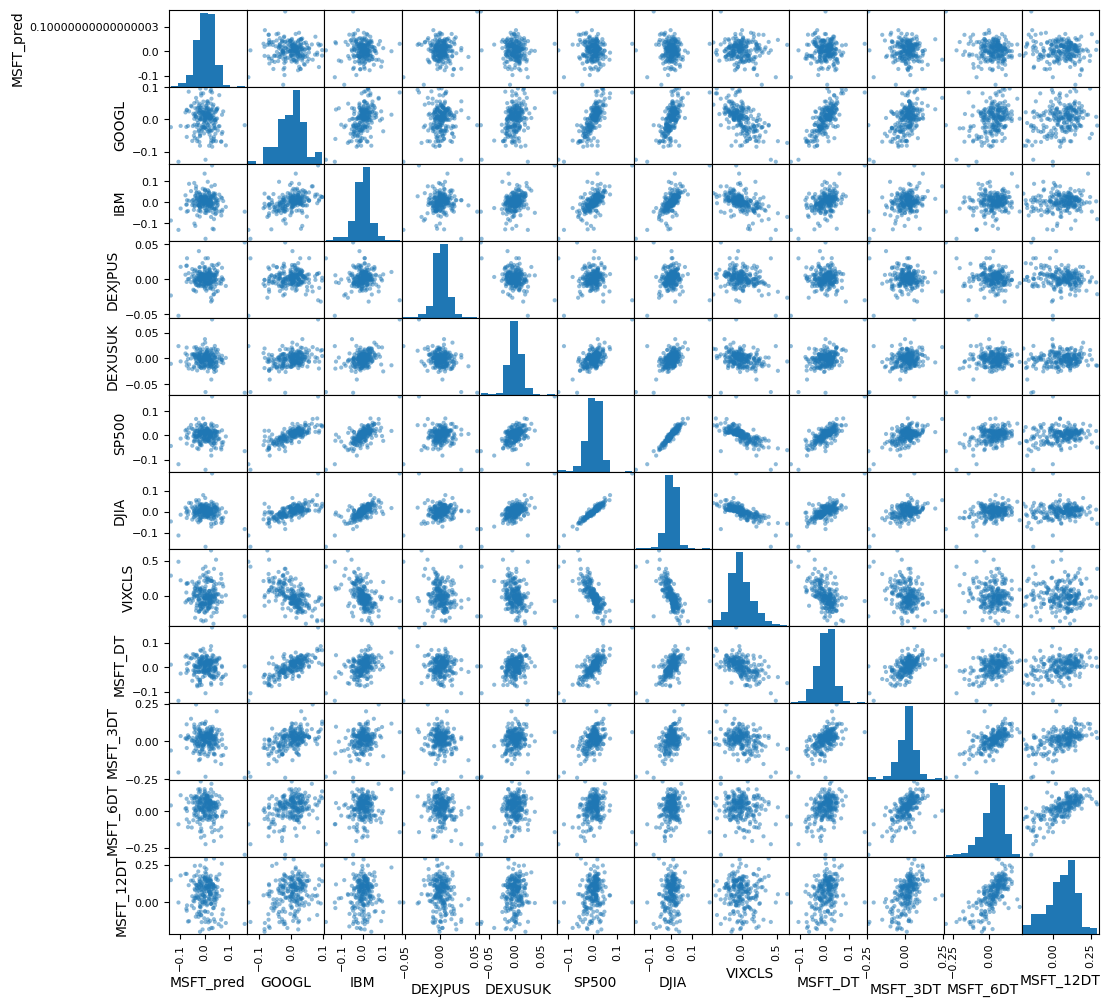

In [21]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

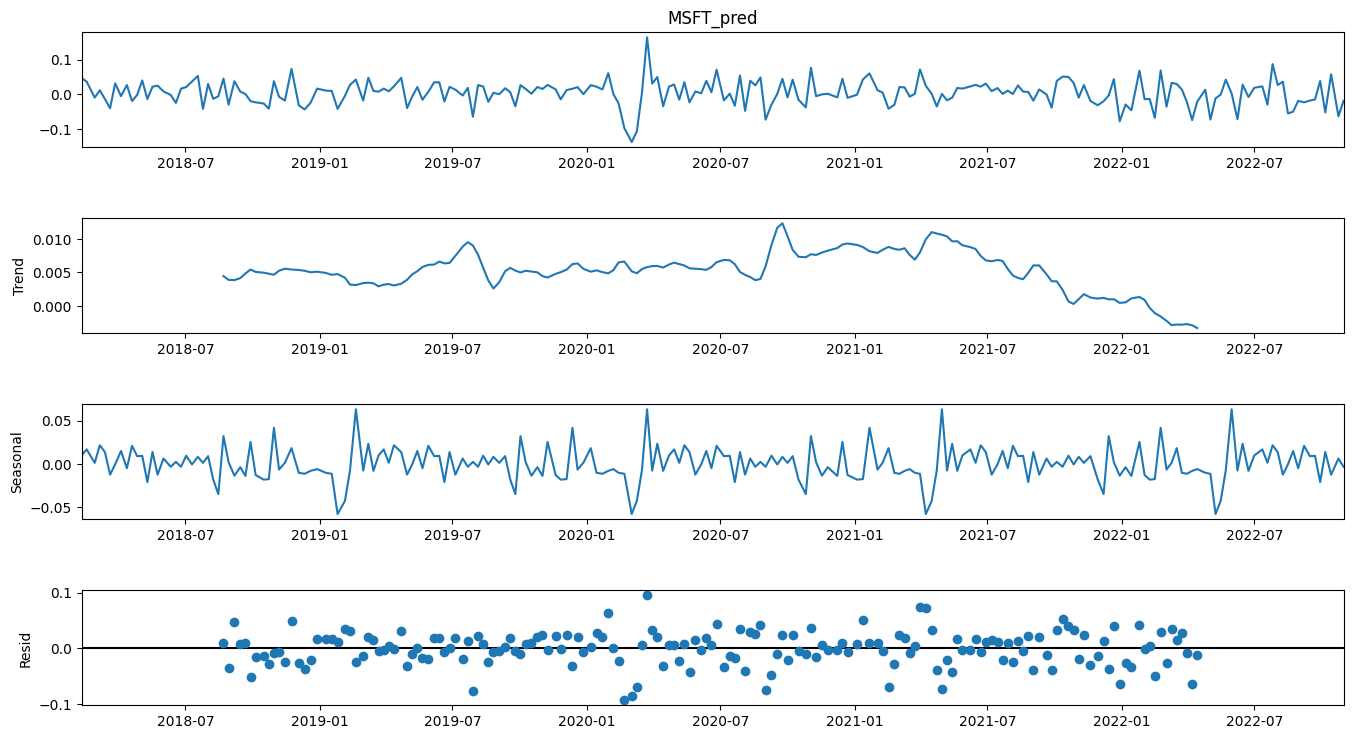

In [22]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

In [23]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
DEXUSUK,5.099922
MSFT_6DT,4.568713
MSFT_3DT,2.839697
MSFT_12DT,1.958665
DEXJPUS,1.931462
VIXCLS,1.174625
GOOGL,0.557186
SP500,0.427041
DJIA,0.304788


In [24]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [25]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [26]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [27]:
models.append(('MLP', MLPRegressor()))

In [28]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [29]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001203 (0.000596) 0.000984 0.002549
LASSO: 0.001160 (0.000704) 0.001146 0.001924
EN: 0.001160 (0.000704) 0.001146 0.001924
KNN: 0.001414 (0.000762) 0.000997 0.002223
CART: 0.002846 (0.001655) 0.000000 0.003340
SVR: 0.001561 (0.001295) 0.001090 0.001805
MLP: 0.002504 (0.001900) 0.001503 0.002303
ABR: 0.001391 (0.000693) 0.000629 0.002165
GBR: 0.001807 (0.001073) 0.000096 0.002195
RFR: 0.001465 (0.000799) 0.000192 0.001998
ETR: 0.001459 (0.000742) 0.000000 0.002123


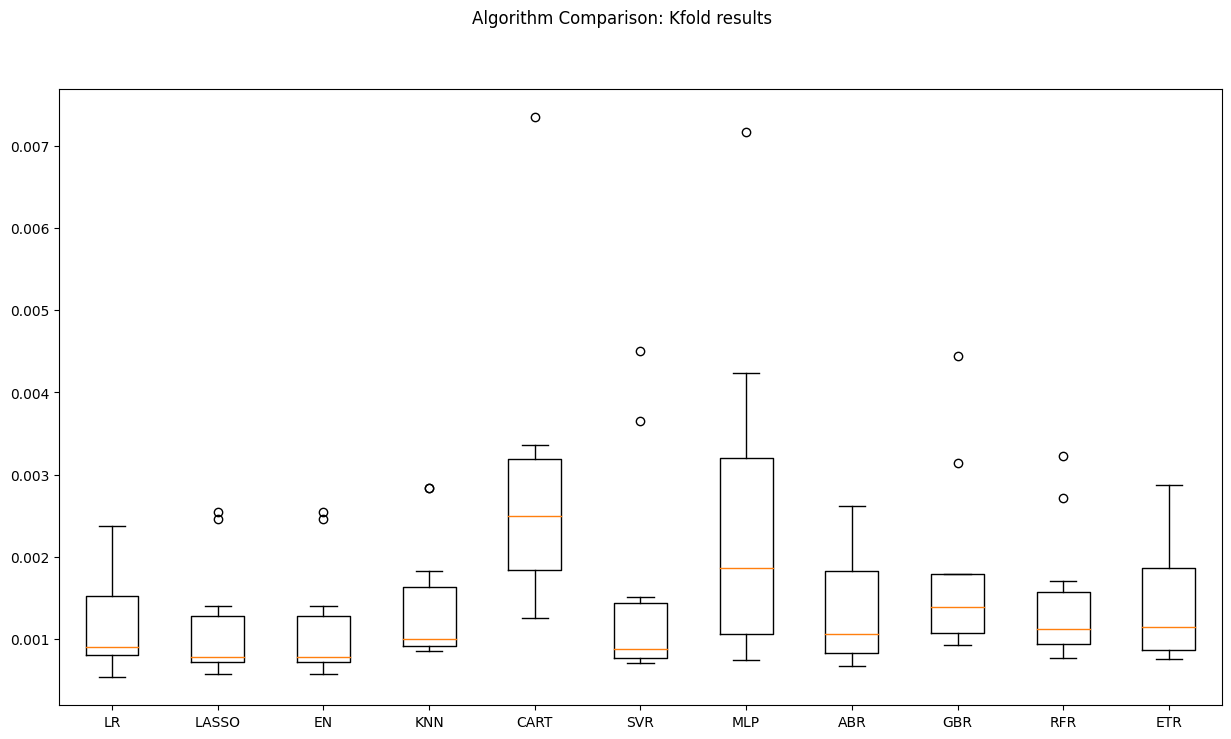

In [30]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

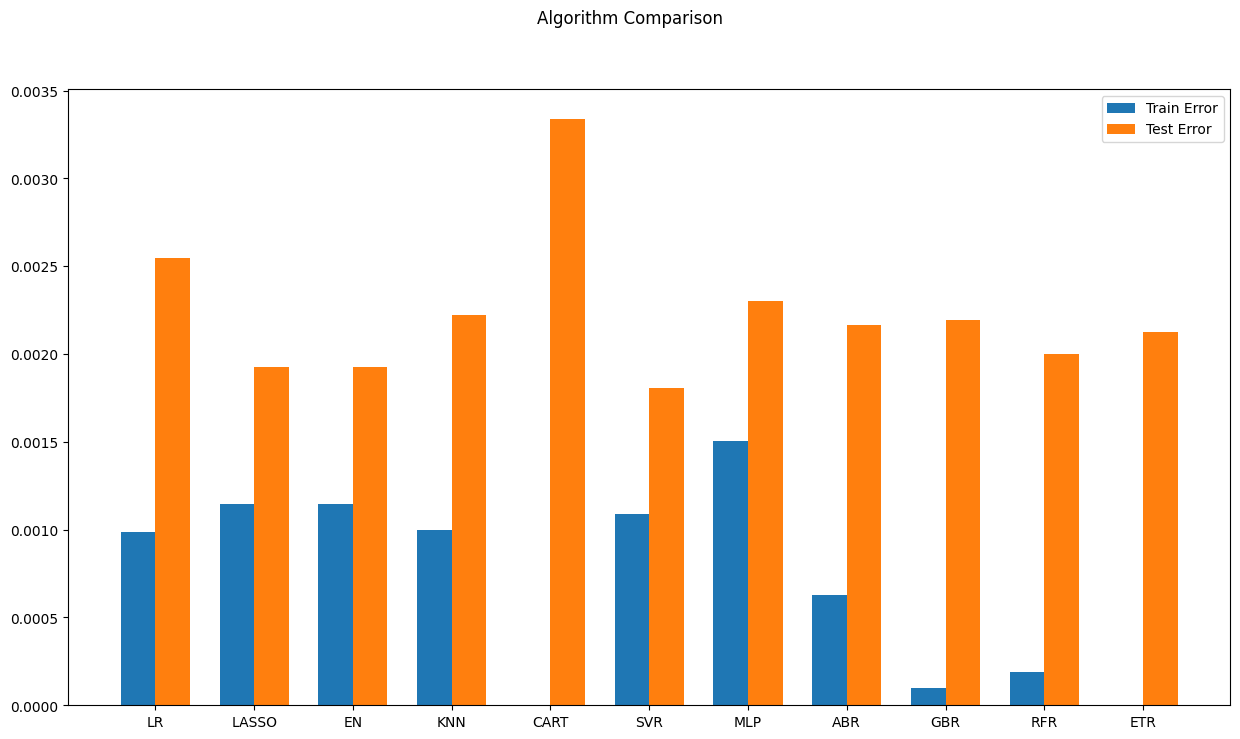

In [31]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. We also see that the
artificial neural network (shown as MLP is the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insuffi‐
cient training of the model.

In [32]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [33]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [34]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.002152658381081306

In [35]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]


In [36]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

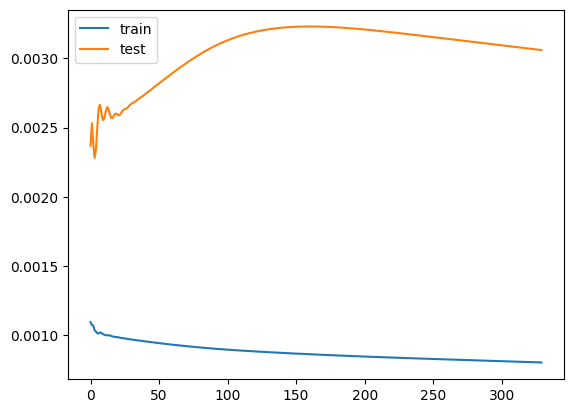

In [37]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [38]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

2/2 [==============================] - 0s 2ms/step


In [39]:
print("Error of Training LSTM: " + str(error_Training_LSTM))
print("Predicted: " + str(predicted))
print("Error Test LSTM: " + str(error_Test_LSTM))

Error of Training LSTM: 0.0008017715437121541
Predicted: [[-0.00362611]
 [ 0.00579007]
 [ 0.00520812]
 [ 0.01396877]
 [ 0.02176822]
 [ 0.02742549]
 [ 0.01842074]
 [ 0.03007883]
 [ 0.04784767]
 [ 0.00703168]
 [ 0.03037206]
 [ 0.0428599 ]
 [ 0.04699918]
 [ 0.02975246]
 [ 0.0183742 ]
 [ 0.01525254]
 [ 0.01605067]
 [ 0.02208894]
 [ 0.02807631]
 [ 0.03660148]
 [ 0.04238632]
 [ 0.04164562]
 [ 0.03300892]
 [ 0.02796207]
 [ 0.03277576]
 [ 0.02932424]
 [ 0.02078854]
 [ 0.05686969]
 [ 0.04473014]
 [ 0.01542383]
 [ 0.02446364]
 [ 0.03547034]
 [-0.00082598]
 [ 0.01347082]
 [ 0.00142803]
 [ 0.02181628]
 [ 0.00852081]
 [ 0.03453119]
 [ 0.02689486]
 [ 0.04726849]
 [ 0.06186497]
 [ 0.05713774]
 [ 0.03525597]
 [ 0.02279594]
 [ 0.03183385]]
Error Test LSTM: 0.003059649325703672


In [40]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

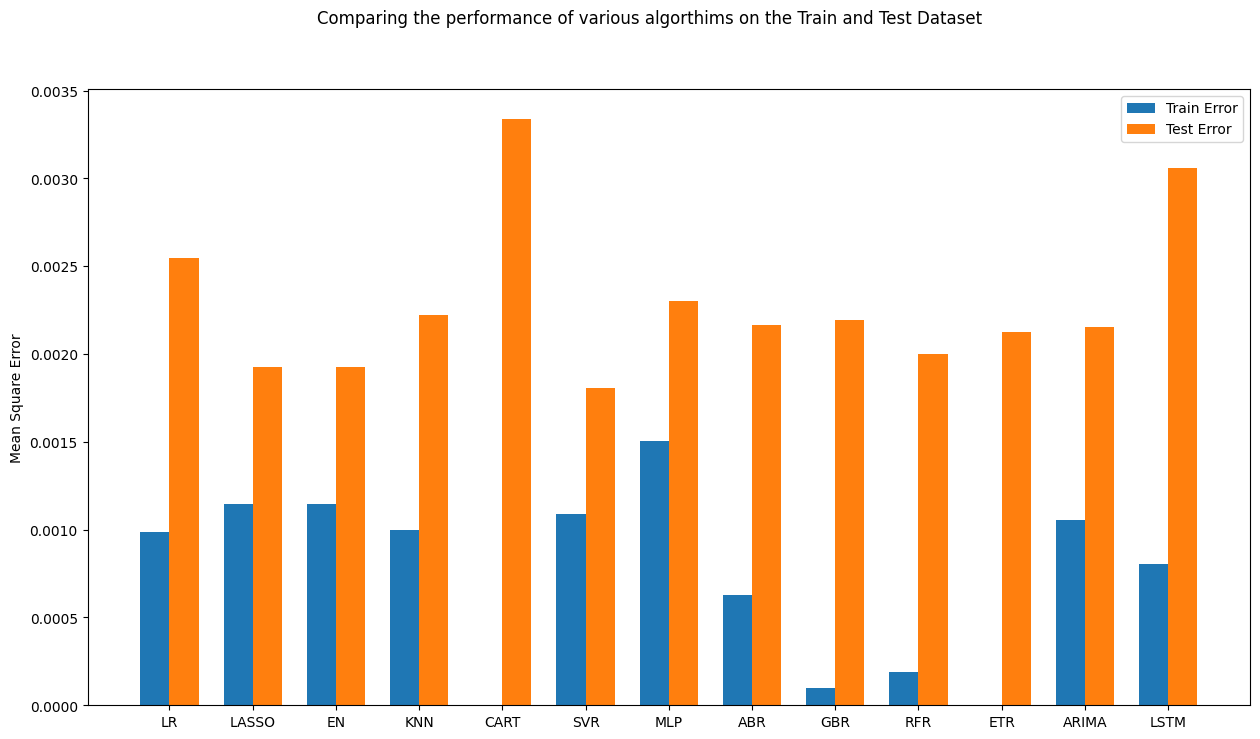

In [41]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

In [42]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0010666
ARIMA(0, 0, 1) MSE=0.0010547
ARIMA(0, 1, 0) MSE=0.0016125
ARIMA(0, 1, 1) MSE=0.0011225
ARIMA(1, 0, 0) MSE=0.0010540
ARIMA(1, 0, 1) MSE=0.0010546
ARIMA(1, 1, 0) MSE=0.0014951
ARIMA(1, 1, 1) MSE=0.0010939
ARIMA(2, 0, 0) MSE=0.0010536
ARIMA(2, 0, 1) MSE=0.0010538
ARIMA(2, 1, 0) MSE=0.0014400
ARIMA(2, 1, 1) MSE=0.0011180
Best ARIMA(2, 0, 0) MSE=0.0010536


In [43]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [44]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.002152658381081306


In [45]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

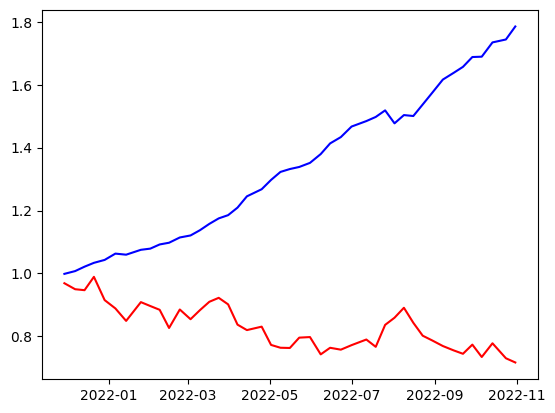

In [46]:
#Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()